In [1]:
# !pip install ccxt scikit-learn pandas numpy matplotlib seaborn mplfinance # tensorflow

In [2]:
import ccxt
import talib
import numpy as np
import pandas as pd
import mplfinance as mpf
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [3]:
exchange = ccxt.binance({'enableRateLimit': True,})
symbol = 'XRP/USDT:USDT'
timeframe = '1m'
limit = 300

ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)

df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

print(df.tail())

                       open    high     low   close    volume
timestamp                                                    
2025-10-05 19:22:00  2.9542  2.9568  2.9538  2.9558  421925.2
2025-10-05 19:23:00  2.9558  2.9585  2.9558  2.9580  351758.1
2025-10-05 19:24:00  2.9580  2.9618  2.9580  2.9618  519929.3
2025-10-05 19:25:00  2.9617  2.9618  2.9602  2.9602  260662.9
2025-10-05 19:26:00  2.9602  2.9607  2.9600  2.9606   79123.2


In [4]:
df['MAX']      = talib.MAX(df['close'], timeperiod=14)
df['MIN']      = talib.MIN(df['close'], timeperiod=14)
df['RSI']      = talib.RSI(df['close'], timeperiod=14)
df['DX']       = talib.DX(df['high'], df['low'], df['close'], timeperiod=14)
df['ADX']      = talib.ADX(df['high'], df['low'], df['close'], timeperiod=14)
df['ADXR']     = talib.ADXR(df['high'], df['low'], df['close'], timeperiod=14)
df['TRANGE']   = talib.TRANGE(df['high'], df['low'], df['close'])
df['ATR']      = talib.ATR(df['high'], df['low'], df['close'], timeperiod=14)
df['MFI']      = talib.MFI(df['high'], df['low'], df['close'], df['volume'], timeperiod=14)
df['MINUS_DI'] = talib.MINUS_DI(df['high'], df['low'], df['close'], timeperiod=14)
df['PLUS_DI']  = talib.PLUS_DI(df['high'], df['low'], df['close'], timeperiod=14)
df['OBV']      = talib.OBV(df['close'], df['volume'])
df['STDDEV']   = talib.STDDEV(df['close'], timeperiod=14, nbdev=1)

df.dropna(inplace=True)

print(df.tail())

                       open    high     low   close    volume     MAX     MIN  \
timestamp                                                                       
2025-10-05 19:22:00  2.9542  2.9568  2.9538  2.9558  421925.2  2.9563  2.9498   
2025-10-05 19:23:00  2.9558  2.9585  2.9558  2.9580  351758.1  2.9580  2.9498   
2025-10-05 19:24:00  2.9580  2.9618  2.9580  2.9618  519929.3  2.9618  2.9498   
2025-10-05 19:25:00  2.9617  2.9618  2.9602  2.9602  260662.9  2.9618  2.9498   
2025-10-05 19:26:00  2.9602  2.9607  2.9600  2.9606   79123.2  2.9618  2.9498   

                           RSI         DX        ADX       ADXR  TRANGE  \
timestamp                                                                 
2025-10-05 19:22:00  42.688246  35.659006  55.484531  47.670035  0.0030   
2025-10-05 19:23:00  47.654136  23.665424  53.211737  47.984008  0.0027   
2025-10-05 19:24:00  54.919937   4.374824  49.723386  47.633606  0.0038   
2025-10-05 19:25:00  51.667988   4.374824  46.484203  47.

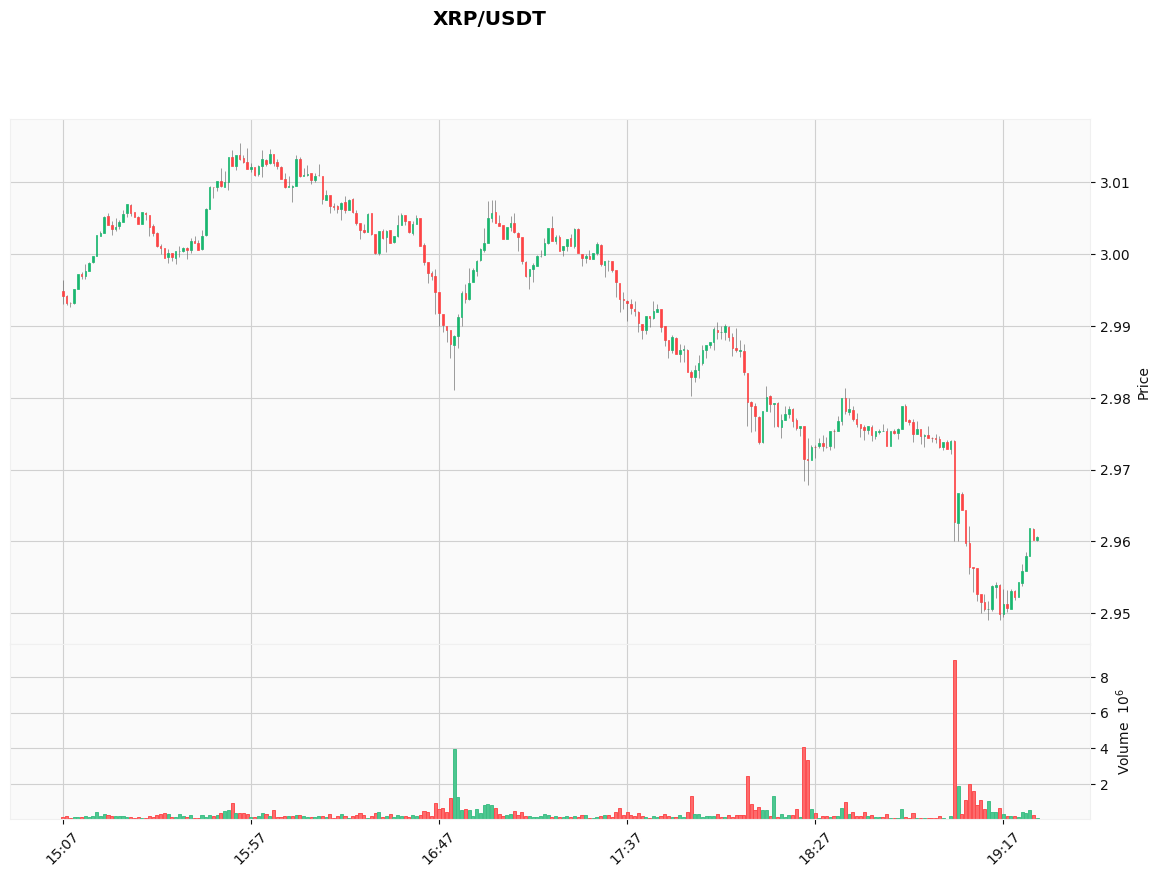

In [5]:
mpf.plot(
    df,
    type='candle',
    volume=True,
    style='yahoo',
    title='XRP/USDT',
    figsize=(15, 10),
    panel_ratios=(3,1)
)

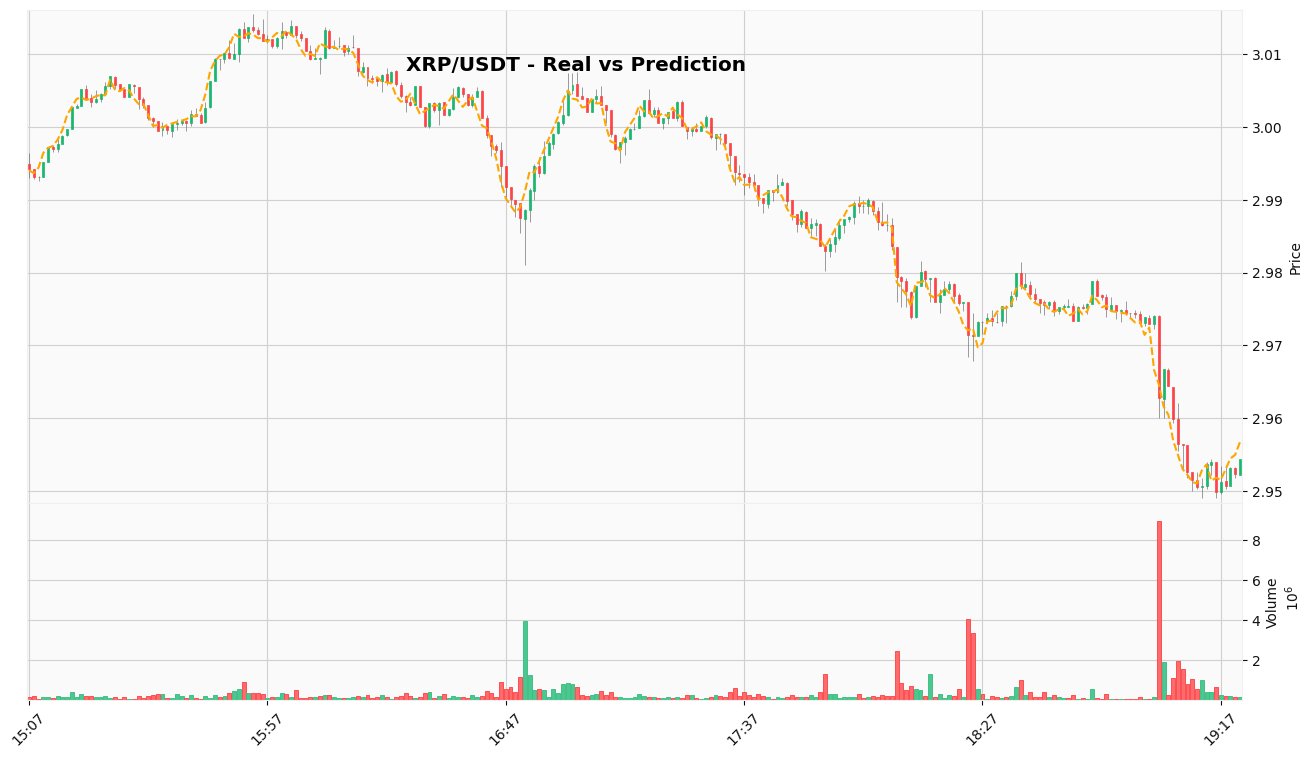

In [6]:
for i in range(1, 6):
    df[f'close_future_{i}'] = df['close'].shift(-i)

df.dropna(inplace=True)

feature_cols = [
    'open', 'high', 'low', 'close', 'volume',
    'MAX', 'MIN', 'RSI', 'DX', 'ADX', 'ADXR',
    'TRANGE', 'ATR', 'MFI', 'MINUS_DI', 'PLUS_DI',
    'OBV', 'STDDEV'
]
features = df[feature_cols]
targets = df[[f'close_future_{i}' for i in range(1, 6)]]

X_train, X_test, y_train, y_test = train_test_split(
    features, targets, test_size=0.2, random_state=42
)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

pred_all = model.predict(features)

pred_cols = [f'pred_close_future_{i}' for i in range(1, 6)]
df_pred_all = pd.DataFrame(pred_all, columns=pred_cols, index=df.index)

df_full = pd.concat([df, df_pred_all], axis=1)

pred_series = df_full['pred_close_future_1']

line_pred = mpf.make_addplot(
    pred_series,
    type='line',
    color='orange',
    width=1.5,
    linestyle='--',
    panel=0,
    secondary_y=False
)

mpf.plot(
    df_full,
    type='candle',
    style='yahoo',
    volume=True,
    addplot=[line_pred],
    title='XRP/USDT - Real vs Prediction',
    ylabel='Price',
    ylabel_lower='Volume',
    figsize=(14, 8),
    tight_layout=True
)
